## Extract amplicons from MAF alignment
- test run for alignments of >=5 genomes - bimodal distribution: apart from almost all species alginments, there are ~7 species (gambiae complex) alignments
- relaxed amplicon search parameters: allow missing species in alignment (max 11), shorter flanks (40 bp) and longer inserts (200 bp)
- filter amplicons variable target (940 markers left)
- extend amplicons
- discriminative power analysis (aka clusters of identical sequences), remove if less than 10 identified lineages 
- annotate amplicons with genes and repeats, remove amplicons with repeats (663 markers left)
- write combined maf and metadata

Hints from downstream analysis:
- length filter should be applied for agam reference length, not only to aligned length
- within-intron markers are not treated as introns, but can be estimated from Gene=AGAP* and Exon=None

__Next__, rerun tree shape analysis, Aedes/Culex/Dmel blast, and assign priority to markers.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pybedtools
from Bio import Phylo
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from collections import Counter
from scipy.stats import gaussian_kde

## Filenames and parameters

In [ ]:
DATA_DIR = "../../../data/"
# multiple genome alignment file from Neafsey et al 2015 Science paper
CHR_FILE = DATA_DIR + "AgamP3_21genome_maf/chr{}.maf"
# annotations from VectorBase
GENES = pybedtools.BedTool(DATA_DIR + "genome/agamP3/Anopheles-gambiae-PEST_BASEFEATURES_AgamP3.8.gff3.gz")
REPEATS = pybedtools.BedTool(DATA_DIR + "genome/agamP3/Anopheles-gambiae-PEST_REPEATFEATURES_AgamP3.gff3.gz")
AMPL_FILE = "data/20180619_comb_ampl.maf"
TREE_FILE = "data/20180619_comb_ampl_tree.nwk"
META_FILE = "data/20180619_comb_ampl_data.csv"

In [5]:
# Alignment filtering parameters
min_species = 10 # minimum number of species in alignment 
min_aligned = 150 # minimum alignment length, also used as minimum amplicon length
                  # relaxed compared to first iteration (190)
min_conserved = 40 # minimum length of flanks with given conservation level (used for primer design), 
                   # here set lower than in the first iteration (50)
max_xs = 0.1 # maximum proportion of indels (represented as X) in flanks
max_ns = 0.1 # maximum proportion of substitutions (represented as N) in flanks

max_insert = 200 # maximum length of non-conserved sequence between two conserved flank
                 # increased compared to first iteration (100)
    
min_id_lineages = 10 # minimum number of distinct sequences in alignment
                     # this cutoff removes ubiquitous gambiae complex-only alignments



## Find amplicons in alignment - min 5 species (test)

In [5]:
def seq_repr(alignment):
    '''
    Given multiple sequence alignment, return first sequence with Ns for ambiguous chars and X's for indels.'''
    seq = ''
    for i in range(alignment.get_alignment_length()):
        col = alignment[:, i]
        if '-' in col: # indel has higher priority than substitution
            seq += 'X'
        elif len(set(col)) == 1:
            seq += col[0]
        else:
            seq += 'N'
    return seq

def get_conserved_subsequences(seq, max_ns, max_xs, min_len):
    '''
    Given sequence, substitution (max_ns) and indel (max_xs) levels, and minimum subsequence length
    return list of tuples for the subsequences with given conservation level (overlapping regions merged).
    If no conserved subsequences found, return 'None'.'''
    slen = len(seq)
    if slen < min_len:
        return None
    
    def is_conserved(s, max_ns, max_xs):
        if s.count('N')/len(s) <= max_ns and s.count('X')/len(s) <= max_xs:
            return True
        else:
            return False
        
    cons_windows = [is_conserved(seq[i:i + min_len], max_ns, max_xs) for i in range(slen - min_len + 1)]
    if sum(cons_windows) == 0:
        return None
    
    cons_kernels = []
    in_kernel = False
    for i, cw in enumerate(cons_windows):
        if in_kernel:
            if cw == False:
                in_kernel = False
                cons_kernels.append(i + min_len)
        elif cw == True:
            cons_kernels.append(i)
            in_kernel = True
    if in_kernel:
        cons_kernels.append(i + min_len) 
        
    # merge overlapping kernels
    merged_kernels = []
    for i in range(len(cons_kernels)//2):
        start = cons_kernels[i * 2]
        end = cons_kernels[i * 2 + 1]
        if not merged_kernels:
            merged_kernels.append((start, end))
        else:
            prev_start = merged_kernels[-1][0]
            prev_end = merged_kernels[-1][1]
            if prev_end >= start:
                upper_bound = max(prev_end, end)
                merged_kernels[-1] = (prev_start, upper_bound)  # replace by merged interval
            else:
                merged_kernels.append((start, end))
    
    return np.asarray(merged_kernels)

# functions test
# for alignment in AlignIO.parse("../../data/AgamP3_maf/chr2L.maf", "maf"):
#     if len(alignment) >= min_species and alignment.get_alignment_length() >= min_aligned:
#         seq = seq_repr(alignment)
#         cons = get_conserved_subsequences(seq, max_ns=max_ns, max_xs=max_xs, min_len=min_conserved)
#         if cons is not None: # conser
#             print(seq)
#             print(cons, cons[:,1] - cons[:,0])
#             break

In [6]:
# Candidate amplicon search - within conserved sequences and between consecutive conserved sequences
def get_candidate_amplicons(cons, min_len, max_insert):
    '''
    Given conserved subsequence intervals, minimum amplicon length and maximum insert length,
    return list of plausible amplicons with insert positions'''
    ampls = []
    for reg in cons: # internal amplicons
        if reg[1] - reg[0] >= min_len:
            ampls.append((reg[0], reg[1], 0, 0))
    for i in range(len(cons) - 1):
        for j in range(i + 1, len(cons)):
            if cons[j, 0] - cons[i, 1] <= max_insert:
                if cons[j, 1] - cons[i, 0] >= min_len:
                    ampls.append((cons[i, 0], cons[j, 1],
                                  cons[i, 1], cons[j, 0]))
    return ampls

# function test - long run
# for alignment in AlignIO.parse("../../data/AgamP3_maf/chr2L.maf", "maf"):
#     if len(alignment) >= min_species and alignment.get_alignment_length() >= min_aligned:
#         seq = seq_repr(alignment)
#         cons = get_conserved_subsequences(seq, max_ns=max_ns, max_xs=max_xs, min_len=min_conserved)
#         if cons is not None:
#             ampls = get_candidate_amplicons(cons, min_aligned, max_insert)
#             if len(ampls) > 0:
#                 for reg in cons:
#                     print(reg, seq[reg[0]:reg[1]])
#                 for ampl in ampls:
#                     print(alignment[:, ampl[0]:ampl[1]])
#                 print(ampls)
#                 break

In [207]:
def gapped_coord(aln, coord, ref=0):
    '''
    Transforms coordinate in maf alignment according to number of gaps in ref (i-th seq in alignment)
    '''
    ngaps = str(aln[ref, :coord].seq).count('-')
    return aln[ref].annotations['start'] + coord - ngaps

def alignment_to_amplicons(alignment, min_species, min_aligned, max_xs, max_ns, 
                           min_conserved, max_insert, annotated=True):
    '''
    Given alignment and filtering paramters
    return list of (alignment, target start, target end)
    '''
    ampl_data = []
    if len(alignment) >= min_species and alignment.get_alignment_length() >= min_aligned:
        seq = seq_repr(alignment)
        cons = get_conserved_subsequences(seq, max_ns=max_ns, max_xs=max_xs, min_len=min_conserved)
        if cons is not None:
            ampls = get_candidate_amplicons(cons, min_aligned, max_insert)
            if len(ampls) > 0:
                for ampl in ampls:
                    ampl_aln = alignment[:, ampl[0]:ampl[1]]
                    if annotated:
                        ampl_aln[0].annotations = alignment[0].annotations.copy()
                        ampl_aln[0].annotations['start'] = gapped_coord(alignment, ampl[0])
                        ampl_aln[0].annotations['size'] = gapped_coord(alignment, ampl[1]) - ampl_aln[0].annotations['start']
                    ampl_data.append((ampl_aln, (ampl[2] - ampl[0], ampl[3] - ampl[0])))
                return ampl_data
    return None
                    
#function test
test_amplicons = []
for alignment in AlignIO.parse(CHR_FILE.format('3L'), "maf"):
    if alignment[0].annotations['start'] > 9800000:
        a = alignment_to_amplicons(alignment, min_species=21, min_aligned=190, max_xs=0.1, max_ns=0.1, 
                                   min_conserved=40, max_insert=200)
        if a is not None:
            test_amplicons.extend(a)
            print(test_amplicons)
            break
    if alignment[0].annotations['start'] > 9811000:
        break

print(test_amplicons[0][0][0].annotations['start'])

[(<<class 'Bio.Align.MultipleSeqAlignment'> instance (21 records of length 259, SingleLetterAlphabet()) at 10b32ba90>, (67, 170))]
9810327


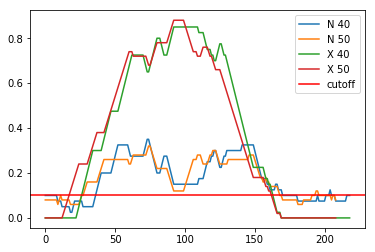

In [246]:
# proportion of variable nucleotides depending on window size
x = seq_repr(test_amplicons[0][0])
for n in ('N','X'):
    for window in (40,50):
        plt.plot([
            (x[i:i+window].count(n)/window) 
            for i in range(len(x)-window)], label='{} {}'.format(n, window))
plt.axhline(y=0.1, color='r', linestyle='-', label='cutoff')
plt.legend();
# insert size becomes higher than conservative cutoff for this intron marker - increase maximum variable insert 

In [15]:
%%time
amplicons = []
# exctract amplicons
for chrom in ('2L', '2R', '3L', '3R', 'X', 'Unkn'):
    print(CHRX_FILE.format(chrom))
    for alignment in AlignIO.parse(CHR_FILE.format(chrom), "maf"):
        a = alignment_to_amplicons(alignment, min_species, min_aligned, max_xs, max_ns, min_conserved, max_insert, annotated=True)
        if a is not None:
            amplicons.extend(a)
print(len(amplicons))

/Users/am60/data/AgamP3_21genome_maf/chr2L.maf
/Users/am60/data/AgamP3_21genome_maf/chr2R.maf
/Users/am60/data/AgamP3_21genome_maf/chr3L.maf
/Users/am60/data/AgamP3_21genome_maf/chr3R.maf
/Users/am60/data/AgamP3_21genome_maf/chrX.maf
/Users/am60/data/AgamP3_21genome_maf/chrUnkn.maf
17090
CPU times: user 1h 26s, sys: 20 s, total: 1h 46s
Wall time: 1h 25min 55s


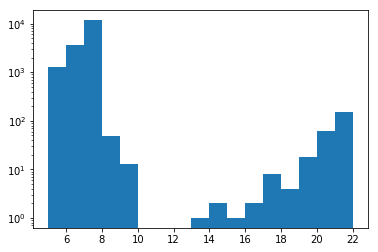

In [99]:
# number of aligned speicies
ax = plt.figure().gca()
ax.hist([len(a[0]) for a in amplicons], bins=range(5, 23))
plt.yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True));
# clearly bimodal distribution

In [26]:
genomes = Counter()
for a in amplicons:
    if len(a[0]) < 12:
        for i in range(len(a[0])):
            genomes[a[0][i].id.split('.')[0]] += 1
print(genomes)
# most markers recovered in ~7 genomes are found only within gambiae group 

Counter({'AgamP3': 16837, 'AaraD1': 16545, 'AgamS1': 16234, 'AmerM1': 16154, 'AquaS1': 16042, 'AgamM1': 15113, 'AmelC1': 14593, 'AchrA1': 68, 'AepiE1': 27, 'AsteS1': 4, 'AsteI2': 4, 'AalbS1': 4, 'AmacM1': 4, 'AminM1': 1, 'AfunF1': 1})


## Find amplicons in alignment - min 10 species (experiment)

In [211]:
%%time
amplicons = []
# exctract amplicons
for chrom in ('2L', '2R', '3L', '3R', 'X', 'UNKN', 'Y_unplaced'):
    print(CHR_FILE.format(chrom))
    for alignment in AlignIO.parse(CHR_FILE.format(chrom), "maf"):
        a = alignment_to_amplicons(alignment, min_species, min_aligned, max_xs, max_ns, min_conserved, max_insert, annotated=True)
        if a is not None:
            amplicons.extend(a)
print(len(amplicons))

/Users/am60/data/AgamP3_21genome_maf/chr2L.maf
/Users/am60/data/AgamP3_21genome_maf/chr2R.maf
/Users/am60/data/AgamP3_21genome_maf/chr3L.maf
/Users/am60/data/AgamP3_21genome_maf/chr3R.maf
/Users/am60/data/AgamP3_21genome_maf/chrX.maf
/Users/am60/data/AgamP3_21genome_maf/chrUNKN.maf
/Users/am60/data/AgamP3_21genome_maf/chrY_unplaced.maf
1158
CPU times: user 54min 37s, sys: 17 s, total: 54min 54s
Wall time: 55min 24s


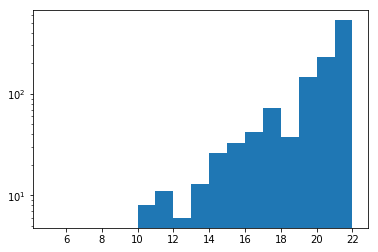

In [212]:
# number of aligned speicies
ax = plt.figure().gca()
ax.hist([len(a[0]) for a in amplicons], bins=range(5, 23))
plt.yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True));

## Remove amplicons without targets

In [213]:
flt_amplicons = [a for a in amplicons if a[1][0] > 0]
len(flt_amplicons)

940

In [214]:
# check for the most informative marker from first iteration
for a in amplicons:
    if a[0][0].annotations['start'] > 9810300 and a[0][0].annotations['start'] < 9810500:
        print(a)

(<<class 'Bio.Align.MultipleSeqAlignment'> instance (21 records of length 259, SingleLetterAlphabet()) at 10dec0898>, (67, 170))


## Extend variable insert

In [215]:
def prop_var(seq):
    '''
    Return propotion of variable nucleotides in seq_repr of alignment'''
    return (seq.count('N') + seq.count('X'))/len(seq)

def extend_variable(seq, start, end, min_ambig=0.5):
    '''
    Extends flanks of variable insert. Works only if seq[0:start] and seq[end:len(seq)] are conserved.
    This should be true for pre-selected amplicons (see 20180223).
    Parameters - sequence, start and end of variable target to be extended,
    minimum proportion of variable sites for extended region. '''
    var_start = False
    for i in range(0, start - 1):
        if prop_var(seq[i:start]) >= min_ambig:
            #print(seq[i:start])
            var_start = True
        if var_start:
            if seq[i] in 'NX':
                ext_start = i
                #print(ext_start)
                break
    else:
        ext_start = start
    
    var_end = False
    for i in reversed(range(end + 1,len(seq))):
        if prop_var(seq[end:i]) >= min_ambig:
            #print(seq[end:i])
            var_end = True
        if var_end:
            if seq[i - 1] in 'NX':
                ext_end = i
                #print(ext_end)
                break
    else:
        ext_end = end
    
    return (ext_start, ext_end)


In [216]:
long_amplicons = []
for a in flt_amplicons:
    seq = seq_repr(a[0])
    (start, end) = extend_variable(seq, a[1][0], a[1][1])
    insert = seq[start:end]
    long_amplicons.append([a[0], seq, start, end, insert])
display(flt_amplicons[0], long_amplicons[0])

(<<class 'Bio.Align.MultipleSeqAlignment'> instance (21 records of length 185, SingleLetterAlphabet()) at 10be4bc18>,
 (51, 141))

[<<class 'Bio.Align.MultipleSeqAlignment'> instance (21 records of length 185, SingleLetterAlphabet()) at 10be4bc18>,
 'CGNAACGGTAGAGGACGTTTNGTTGGTGTNCCTGGNAGCGANAGAAAACCNNTGGTACTNTCAACATATCTNGANGCNCANGAACANNTGCCNTANGCNGANGATTCNAANGCNGTNACNCCNATGTCNGANGAAAATGGNGCAATCATNGTNCCAGTATACTANGCTAANTTAGGTACAXXXXX',
 51,
 141,
 'NTGGTACTNTCAACATATCTNGANGCNCANGAACANNTGCCNTANGCNGANGATTCNAANGCNGTNACNCCNATGTCNGANGAAAATGGN']

## Discriminative power analysis (identical clusters) 

In [217]:
def identical_clusters(aln):
    '''
    Given alignment, return list of sets with species IDs with identical sequences'''
    

    ids = [set()]
    dm = DistanceCalculator('identity').get_distance(aln)
    dm.names = [n.split('.')[0] for n in dm.names]
    for i in range(len(dm)):
        for j in range(i + 1, len(dm)):
            if dm[i,j] == 0:
                n1 = dm.names[i]
                n2 = dm.names[j]
                for cl in ids:
                    if (n1 in cl):
                        if (n2 in cl):
                            break
                        if (n2 not in cl):
                            cl.add(n2)
                            break
                else:
                    ids.append(set((n1, n2)))
    
    id_clusters = ids[1:]
    
    discrim = len(dm) - sum([len(cl)-1 for cl in id_clusters]) 
        
    return [id_clusters, discrim]

cl_amplicons = []

for a in long_amplicons:
    target = a[0][:, a[2]:a[3]]
    cl_amplicons.append(a + identical_clusters(target))

cl_amplicons[0]

[<<class 'Bio.Align.MultipleSeqAlignment'> instance (21 records of length 185, SingleLetterAlphabet()) at 10be4bc18>,
 'CGNAACGGTAGAGGACGTTTNGTTGGTGTNCCTGGNAGCGANAGAAAACCNNTGGTACTNTCAACATATCTNGANGCNCANGAACANNTGCCNTANGCNGANGATTCNAANGCNGTNACNCCNATGTCNGANGAAAATGGNGCAATCATNGTNCCAGTATACTANGCTAANTTAGGTACAXXXXX',
 51,
 141,
 'NTGGTACTNTCAACATATCTNGANGCNCANGAACANNTGCCNTANGCNGANGATTCNAANGCNGTNACNCCNATGTCNGANGAAAATGGN',
 [{'AaraD1', 'AgamM1', 'AgamP3', 'AgamS1', 'AmelC1', 'AquaS1'},
  {'AsteI2', 'AsteS1'},
  {'AatrE1', 'AsinS1'}],
 14]

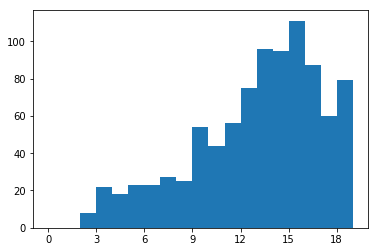

In [218]:
# how many lineages can each amplicon discriminate?
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.hist([a[-1] for a in cl_amplicons], bins=range(20))
ax.xaxis.set_major_locator(MaxNLocator(integer=True));

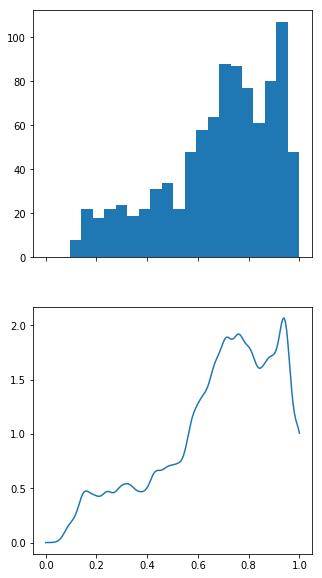

In [219]:
# divide number of species aligned to obtain estimates of relative informativeness
data = [a[-1]/len(a[0]) for a in cl_amplicons]
density = gaussian_kde(data)
xs = np.linspace(0,1,200)
density.covariance_factor = lambda : .1
density._compute_covariance()
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 10))
ax1.hist(data, bins=20)
ax2.plot(xs,density(xs))
plt.show()

753

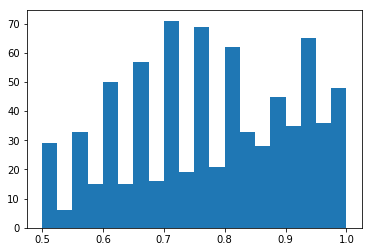

In [220]:
# set identification power cutoff of 0.5
# unique sequences divided by total sequences in alignment
# unused in current variation
info_amplicons = [a for a in cl_amplicons if a[-1]/len(a[0]) >= 0.5]
plt.hist([a[-1]/len(a[0]) for a in info_amplicons], bins=20);
display(len(info_amplicons))

In [227]:
len(cl_amplicons)

940

## Create metadata

In [250]:
amplicon_stats = []
for aln in cl_amplicons:
    amplicon_stats.append({
        'seqid': aln[0][0].id,
        'start': aln[0][0].annotations['start'],
        'end': gapped_coord(aln[0], aln[0].get_alignment_length()),
        'aligned_len': aln[0].get_alignment_length(),
        'snvs': aln[1].count('N'),
        'indels': aln[1].count('X'),
        'target_start': gapped_coord(aln[0], aln[2]),
        'target_end': gapped_coord(aln[0], aln[3]),
        'target_aligned_len': aln[3] - aln[2],
        'target_snvs': aln[4].count('N'),
        'target_indels': aln[4].count('X'),
        'aligned_species': len(aln[0]),
        'unid_species': aln[5],
        'id_lineages': aln[6],
        'informativeness': aln[6]/len(aln[0]),
        'chr': aln[0][0].id[10:],
        'alignment': aln[0]
    })
meta = pd.DataFrame(amplicon_stats)
display(meta.shape)
# explore markers per chromsome
meta['chr'].value_counts()

(940, 17)

3R      268
2R      262
2L      199
3L      154
X        33
UNKN     24
Name: chr, dtype: int64

## Annotate amplicons - genes and repeats

In [229]:
# create list of BED intervals for amplicons
amplicon_beds = meta[['chr', 'start', 'end']].to_string(header=False, index=False).split('\n')
amplicon_beds[0]

'2L   2403094   2403278'

In [230]:
def bt_to_df(bt):
    '''
    Convert bedtool to pandas dataframe replacing empty files with None'''
    if len(bt) > 0:
        return bt.to_dataframe()
    else:
        return None
    
def annotate_interval(bed_str, genes, repeats):
    '''
    Annotate interval in string format genes and repats annotation tracks
    '''
    def bt_to_df(bt):
        '''
        Convert bedtool to pandas dataframe'''
        if len(bt) > 0:
            return bt.to_dataframe()
        else:
            return pd.DataFrame()

    def get_attrs(d, feature, attr_id):
        '''
        From gff dataframe extract list of features by attribute ID
        Attribute string example for gene feature:
        ID=AGAP001235;biotype=protein_coding
        '''
        out = []
        try:
            for attr in d[d.feature == feature]['attributes']:
                for a in attr.split(';'):
                    aa = a.split('=')
                    if aa[0] == attr_id:
                        out.append(aa[1])
            if len(out) > 0:
                return ';'.join(out)
        except: # no annotations
            pass
            
        return 'None'
    
    attr_dict = dict()
    
    # intersect
    a_bed = pybedtools.BedTool(bed_str, from_string=True) 
    ag_gff = genes.intersect(a_bed)
    ar_gff = repeats.intersect(a_bed)
    # convert annotations to dataframe
    ampl_annot = pd.concat([bt_to_df(ag_gff), bt_to_df(ar_gff)])
    # extract annotations
    attr_dict = {
    'gene': get_attrs(ampl_annot, 'gene', 'ID'),
    'mRNA': get_attrs(ampl_annot, 'mRNA', 'ID'),
    'exon': get_attrs(ampl_annot, 'exon', 'ID'),
    'repeat': get_attrs(ampl_annot, 'repeat', 'Name'),
    }
    attr_dict['utr'] = ('Yes' if ('utr' in str(ampl_annot['feature'])) else 'None')
    attr_dict['intron'] = ('Yes' if (attr_dict['mRNA'].count(';') < attr_dict['exon'].count(';')) else 'None')
    
    return attr_dict

annotate_interval(amplicon_beds[0], GENES, REPEATS)

{'exon': 'E013980A;E013980B;E013980C',
 'gene': 'AGAP004707',
 'intron': 'None',
 'mRNA': 'AGAP004707-RA;AGAP004707-RB;AGAP004707-RC',
 'repeat': 'None',
 'utr': 'None'}

In [233]:
%%time
# annotation dictionary
ann_dict = dict()
for (i, bed) in enumerate(amplicon_beds):
    ann_dict[i] = annotate_interval(bed, GENES, REPEATS)
pd.DataFrame(ann_dict)

CPU times: user 9.92 s, sys: 11.3 s, total: 21.2 s
Wall time: 1h 10min 12s


In [234]:
# combine metadata, explore repeats
meta_ann = pd.concat([meta, pd.DataFrame(ann_dict).T], axis=1)
display(meta_ann.shape)
meta_ann['repeat'].value_counts()

(940, 23)

None                     858
dust                      59
trf                       12
trf;dust                   3
dust;dust                  3
CR1Fam21_2                 1
trf;trf;dust               1
TSESSEBEII                 1
Agam_U89801_TsessebeI      1
Ty3_gypsy_Ele108           1
Name: repeat, dtype: int64

In [267]:
# remove repeats and <10 lineages
meta_nonrep = meta_ann[(meta_ann['repeat'] == 'None') & (meta_ann['id_lineages'] >= min_id_lineages)]
meta_nonrep.shape

(663, 23)

In [268]:
# markers per gene
meta_nonrep['gene'].value_counts().head(10)

None          294
AGAP010147     15
AGAP002859      7
AGAP002884      6
AGAP001497      6
AGAP005134      6
AGAP012048      6
AGAP008559      5
AGAP006176      5
AGAP003271      5
Name: gene, dtype: int64

Overall, multiple markers per gene are common. Top-2: 

- AGAP010147 - myosin heavy chain (3R:49Mbp)
- AGAP002859 - Na/Ca-exchange protein (dmel) (2R:28Mbp)

In [275]:
# inronic markers
print('{} introns'.format(meta_nonrep[meta_nonrep['intron'] == 'Yes'].shape[0]))
print('{} genes'.format(meta_nonrep[meta_nonrep['intron'] == 'Yes']['gene'].nunique()))

42 introns
38 genes


## Write alignments

In [278]:
# write combined autosomal and X-chromosomal amplicons 
count = 0
with open(AMPL_FILE, "w") as handle:
    for a in meta_nonrep['alignment']:
        count += AlignIO.write(a, handle, "maf")
count

663

In [279]:
# Number of amplicons total
!grep -c AgamP3 {AMPL_FILE}

663


## Write trees

In [10]:
def phylo_tree(aln):
    '''
    Given alignment, return NJ tree in nwk format'''
    calculator = DistanceCalculator('identity')
    dm = calculator.get_distance(aln)     
    dm.names = [n.split('.')[0] for n in dm.names]
    constructor = DistanceTreeConstructor()
    tree = constructor.nj(dm)
    return tree

In [13]:
ampl_alns = AlignIO.parse(AMPL_FILE, "maf")

In [14]:
ampl_trees = [phylo_tree(a) for a in ampl_alns]

In [19]:
with open(TREE_FILE, 'w') as o:
    Phylo.write(trees=ampl_trees, file=o, format='newick')
! wc -l {TREE_FILE}

     663 data/20180619_comb_ampl_tree.nwk


## Write metadata

In [289]:
# final formatting changes (only column-wise)
meta_nonrep['id lineage proportion'] = meta_nonrep.id_lineages / meta_nonrep.aligned_species
meta_nonrep.reset_index(drop=True, inplace=True)
meta_nonrep.drop(columns=['alignment'], inplace=True)
meta_nonrep.tail()

,aligned_len,aligned_species,chr,end,id_lineages,indels,informativeness,seqid,snvs,start,...,target_snvs,target_start,unid_species,exon,gene,intron,mRNA,repeat,utr,id lineage proportion
658,286,21,UNKN,31857759,17,6,0.809524,AgamP3.chrUNKN,43,31857478,...,24,31857533,"[{AquaS1, AmelC1, AgamP3}, {AgamM1, AgamS1}, {...",None,None,None,None,None,None,0.809524
659,254,21,UNKN,31857857,15,76,0.714286,AgamP3.chrUNKN,23,31857641,...,5,31857754,"[{AmerM1, AgamP3, AaraD1, AgamM1, AquaS1, Agam...",None,None,None,None,None,None,0.714286
660,200,19,UNKN,31943559,17,99,0.894737,AgamP3.chrUNKN,18,31943410,...,16,31943447,"[{AgamM1, AgamP3}, {AsteI2, AsteS1}]",None,None,None,None,None,None,0.894737
661,217,17,UNKN,33274168,13,117,0.764706,AgamP3.chrUNKN,14,33274010,...,11,33274053,"[{AgamM1, AmelC1, AaraD1, AgamS1}, {AsteI2, As...",None,None,None,None,None,None,0.764706
662,279,13,UNKN,38751330,10,153,0.769231,AgamP3.chrUNKN,30,38751128,...,24,38751177,"[{AgamM1, AaraD1, AgamS1}, {AsteI2, AsteS1}]",None,None,None,None,None,None,0.769231


In [290]:
meta_nonrep.to_csv(META_FILE)